In the following notebook I train a ResNet34 model using Pytorch and the tool Weights and Biases for experiment tracking.

An accuracy of 0.98346 has been achieved with the following code if trained with all data.

<h1 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;">TABLE OF CONTENTS</h1>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-one">0&nbsp;&nbsp;&nbsp;&nbsp;IMPORTS</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-two">1&nbsp;&nbsp;&nbsp;&nbsp;WEIGHTS & BIASES</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-three">2&nbsp;&nbsp;&nbsp;&nbsp;CONFIG</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-four">3&nbsp;&nbsp;&nbsp;&nbsp;UTILS</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-five">4&nbsp;&nbsp;&nbsp;&nbsp;DATA AUGMENTATION</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-six">5&nbsp;&nbsp;&nbsp;&nbsp;DATASET</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-seven">6&nbsp;&nbsp;&nbsp;&nbsp;MODEL</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-eight">7&nbsp;&nbsp;&nbsp;&nbsp;OPTIMIZER</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-nine">8&nbsp;&nbsp;&nbsp;&nbsp;LOSS FUNCTION</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-ten">9&nbsp;&nbsp;&nbsp;&nbsp;TRAIN</a></h3>

---

<h3 style="text-indent: 10vw; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px;"><a href="#section-eleven">10&nbsp;&nbsp;&nbsp;&nbsp;SUBMISSION</a></h3>


<a id="section-one"></a>
# Imports

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
import cv2
import pandas as pd
import numpy as np

from tqdm import tqdm

import glob
import os
import time
from IPython import display as ipd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

<a id="section-two"></a>
# Weights & Biases
Weights and biases is a developer tool for machine learning. It is the perfect tool for experiment tracking.

In this notebook I will be using W&B for the following:
* Store hyperparameter configuration
* Track in real time metrics and store them for tranings comparison
* Store custom visualizations like confusion matrix

I recommend you to explore it yourself and find what you can do with it https://wandb.ai/site

Additionally, if you are working with kaggle notebooks, you can make use of the add-on Secrets, which allow us to save our W&B API key safely and use it in our notebooks.

In [2]:
!pip install -qU wandb
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("WANDB")
wandb.login(key=api_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

<a id="section-three"></a>
# Config

This is the best configuration I have found so far.

In [3]:
CFG = {
    "batch_size": 32,
    "num_epochs": 10,
    'pretrained': True,
    'init_lr': 0.001,
    'weight_decay': 0,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'model_name': 'resnet34',  # 'efficientnet_b4', 'resnet34'
    'min_lr': 0.001,
    'max_lr': 0.01,
    'patience': 0,
    'gamma': 0.1,
    'momentum': 0.9,
    'optimizer': 'SGD',  # 'SGD', 'Adam'
    'lr_scheduler': 'OneCycleLR',  # None, 'OneCycleLR', 'ReduceLROnPlateau'
    'loss': 'CrossEntropy',
}

<a id="section-four"></a>
# Utils

In [4]:
# stratified split train/validation
def get_train_val(train_path):
    labels = os.listdir(train_path)
    train_data = []
    val_data = []
    for label in labels:
        images_path = glob.glob(f'{train_path}/{label}/*.jpg')
        train_paths, val_paths = train_test_split(images_path, test_size=0.2, random_state=42)
        val_data += val_paths
        train_data += train_paths
    return train_data, val_data


# create confusion matrix from predictions
def create_confusion_matrix(preds, labels):
    cf_matrix = confusion_matrix(labels, preds)
    df_cm = pd.DataFrame(cf_matrix)
    plt.figure(figsize=(12, 7))
    s = sn.heatmap(df_cm, annot=True, fmt='g')
    s.set(xlabel='Estimated', ylabel='Real')
    plt.close('all')
    return s.get_figure()

<a id="section-five"></a>
# Data augmentation
Use Albumentations library for data augmentation https://albumentations.ai/

Albumentations allow us to use very similar transformations to what we can find in torchvision.transforms module. 

The reason of why I use Albumentations is because it offers the largest number of image augmentations than any other image augmentations library, it is much faster than torchvision and it offers native support for augmentation of image & mask, keypoints & bounding boxes.

In [5]:
train_transforms = A.Compose([
    A.OneOf([
        A.Rotate(30, p=1),
        A.HorizontalFlip(p=1),
        A.CenterCrop(height=480,width=480,p=1),
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=1)
    ], p=0.8),
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

<a id="section-six"></a>
# Dataset

In [6]:
class PaddyDoctorDataset(Dataset):
    def __init__(self, data, dataset_name='', transforms=None):
        self.image_paths = data
        self.transforms = transforms
        self.name = dataset_name
        self.labelstoid = {path.split("/")[-2]: 0 for path in self.image_paths}
        for i, j in enumerate(self.labelstoid.keys()):
            self.labelstoid[j] = i
        self.idtolabels = dict((v, k) for k, v in self.labelstoid.items())
        self.num_classes = len(self.labelstoid)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)[:, :, ::-1]  # convert it to rgb
        img = img.astype('float32')
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        label = img_path.split("/")[-2]
        id = self.labelstoid[label]
        encoded_id = np.zeros(self.num_classes, dtype='float32')
        encoded_id[id] = 1
        return img, torch.tensor(encoded_id)
    
    # the following functions are only necessary to visualize distribution
    def get_distribution(self):
        distribution = {}
        splitted_paths = [path.split("/") for path in self.image_paths]
        for splitted_path in splitted_paths:
            if splitted_path[-2] not in distribution:
                distribution[splitted_path[-2]] = 0
            else:
                distribution[splitted_path[-2]] += 1
        return distribution
    
    def plot_distribution(self):
        distribution = self.get_distribution()
        labels = list(distribution.keys())
        values = list(distribution.values())
        #fig = plt.figure(figsize = (20, 5))
        plt.barh(labels, values)
        plt.xlabel("N samples")
        plt.title(f"{self.name}")
        plt.show()

Split dataset in train and validation in a stratified way, having the same percentatge of representation for every class in train and validation.

In [7]:
train_path = '/kaggle/input/paddy-disease-classification/train_images'
train_data, val_data = get_train_val(train_path)

train_dataset = PaddyDoctorDataset(train_data, dataset_name='train', transforms=train_transforms)
val_dataset = PaddyDoctorDataset(val_data, dataset_name='validation', transforms=val_transforms)
train_dl = DataLoader(train_dataset, batch_size=CFG['batch_size'], shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=CFG['batch_size'], shuffle=True)
# get number of classes
num_classes = train_dataset.num_classes

Check that both train and validation dataset are stratified

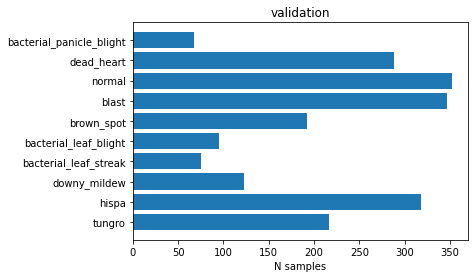

In [8]:
train_dataset.plot_distribution()
val_dataset.plot_distribution()

<a id="section-seven"></a>
# Model

In [9]:
class CustomModel(nn.Module):
    def __init__(self, num_classes, model_name, pretrained=True):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet_b4':
            self.model = models.efficientnet_b4(pretrained=pretrained)
            in_features = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
        elif model_name == 'resnet34':
            self.model = models.resnet34(pretrained=pretrained)
            in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(in_features=in_features, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
model = CustomModel(num_classes, model_name=CFG['model_name'], pretrained=CFG['pretrained'])
model = model.to(CFG['device'])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

<a id="section-eight"></a>
# Optimizer

In [11]:
if CFG['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=CFG['init_lr'], weight_decay=CFG['weight_decay'])
elif CFG['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=CFG['init_lr'], momentum=CFG['momentum'], weight_decay=CFG['weight_decay'])

## Learning rate scheduler

In [12]:
if CFG['lr_scheduler'] == None:
    scheduler = None
elif CFG['lr_scheduler'] == 'OneCycleLR':
    scheduler = OneCycleLR(optimizer, max_lr=CFG['max_lr'], steps_per_epoch=len(train_dl), epochs=CFG['num_epochs'])
elif CFG['lr_scheduler'] == 'ReduceLROnPlateau':
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG['gamma'], patience=CFG['patience'], min_lr=CFG['min_lr'])

<a id="section-nine"></a>
# Loss function

In [13]:
def criterion(inputs, targets):
    if CFG['loss'] == 'CrossEntropy':
        loss = F.cross_entropy(inputs, targets)
    return loss

<a id="section-ten"></a>
# Train

Save metrics in a python dictionary, which can be sent to W&B as a log.

In [14]:
log = {}

In [15]:
def train_epoch(model, dataloader, optimizer, scheduler, epoch):
    model.train()
    running_loss = 0.0
    dataset_size = 0
    log["lr"] = optimizer.param_groups[0]['lr']
    # use tqdm to track progress
    with tqdm(dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch} train")
        # Iterate over data.
        for inputs, targets in tepoch:
            inputs = inputs.to(CFG['device'])
            targets = targets.to(CFG['device'])
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            # loss
            loss = criterion(outputs, targets)
            # backward
            loss.backward()
            optimizer.step()
            if CFG['lr_scheduler'] == 'OneCycleLR':
                scheduler.step()
            # calculate epoch loss
            dataset_size += inputs.size(0)
            running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / dataset_size
            # get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            # print statistics
            tepoch.set_postfix(loss=epoch_loss, lr=current_lr)
    log["train_loss"] = epoch_loss
    return epoch_loss

In [16]:
def val_epoch(model, dataloader, scheduler, epoch):
    model.eval()
    running_loss = 0.0
    dataset_size = 0
    running_corrects = 0
    total_targets_label = []
    total_outputs_label = []
    # use tqdm to track progress
    with tqdm(dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch} val")
        # Iterate over data.
        for inputs, targets in tepoch:
            inputs = inputs.to(CFG['device'])
            targets = targets.to(CFG['device'])
            # predict
            outputs = model(inputs)
            # outputs = self.process_pred(outputs, inputs)
            # loss
            loss = criterion(outputs, targets)
            # calculate epoch loss
            dataset_size += inputs.size(0)
            running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / dataset_size
            # Get target and predicted labels for metrics
            targets_label = torch.max(targets, dim=1)[1]
            outputs_label = torch.max(outputs, dim=1)[1]
            total_outputs_label += outputs_label.tolist()
            total_targets_label += targets_label.tolist()
            # Accuracy
            running_corrects += torch.sum(outputs_label == targets_label).item()
            epoch_acc = running_corrects / dataset_size
            # print statistics
            tepoch.set_postfix(loss=epoch_loss, acc=epoch_acc)
    log['conf_matrix'] = wandb.Image(create_confusion_matrix(total_outputs_label, total_targets_label))
    log["val_loss"] = epoch_loss
    log['acc'] = epoch_acc
    if CFG['lr_scheduler'] == 'ReduceLROnPlateau':
        scheduler.step(epoch_loss)
    return epoch_loss

In [17]:
project_name = "paddy-disease-classification"
run = wandb.init(project=project_name, config=CFG)

since = time.time()
best_loss = 100000
for epoch in range(CFG['num_epochs']):
    train_epoch(model, train_dl, optimizer, scheduler, epoch)
    val_loss = val_epoch(model, val_dl, scheduler, epoch)
    # save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "./best.pt")
    # save logs using wandb
    wandb.log(log)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

run.finish()
display(ipd.IFrame(run.url, width=1000, height=720))

wandb: Currently logged in as: 0miquel. Use `wandb login --relogin` to force relogin


Epoch 9 val: 100%|██████████| 66/66 [00:21<00:00,  3.06batch/s, acc=0.972, loss=0.0892]


Training complete in 28m 24s


<a id="section-eleven"></a>
# Submission

Load model with best validation loss on training.

In [18]:
model_path = "./best.pt"
model = CustomModel(num_classes=num_classes, model_name=CFG['model_name'], pretrained=True)
model.load_state_dict(torch.load(model_path))
model = model.to(CFG['device'])
model.eval()
print("Model ready")

Model ready


Inference for every test image and save results in submission.csv

In [19]:
idtolabels = train_dataset.idtolabels
images_path = glob.glob('/kaggle/input/paddy-disease-classification/test_images/*.jpg')

submission = []
for img_path in tqdm(images_path):
    # process image
    img = cv2.imread(img_path)[:, :, ::-1]  # convert it to rgb
    img = img.astype('float32')
    img = val_transforms(image=img)['image'] # apply same transforms of validation set
    img = img[None, ...].to(CFG['device']) # add batch dimension to image and use device
    # predict 
    pred = model(img) 
    pred = torch.max(pred, dim=1)[1]
    label = idtolabels[pred.item()]
    submission.append([img_path.split("/")[-1], label])
submission = pd.DataFrame(submission, columns=['image_id', 'label'])
submission.to_csv("./submission.csv", index=False)

100%|██████████| 3469/3469 [01:19<00:00, 43.53it/s]
